In [1]:
import pickle
import numpy as np

from mofnet import DataLoader, MOFNet

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import Problem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize
import pymoo.gradient.toolbox as anp

In [2]:
data_loader = DataLoader.from_state("data_loader_state-20200116.npz")

# This hash dicts map budilding block names to unique index.
topo_hash = data_loader.topo_hash
node_hash = data_loader.node_hash
edge_hash = data_loader.edge_hash

mofnet = MOFNet()
mofnet.initialize_weights()
training_name = "cycle_tot"
mofnet.load_weights("cycle_tot/mofnet-{n:}-min.h5".format(n=training_name))

In [3]:
mofnet_n2 = MOFNet()
mofnet_n2.initialize_weights()
training_name = "cycle_tot"
mofnet_n2.load_weights("cycle_tot_n2/mofnet-{n:}-min.h5".format(n=training_name))

In [4]:
def mofnet_prediction(x_test_name):
    test_bulk=data_loader.make_dataset(
        np.array(x_test_name, dtype=str),
        np.array([0.0]*len(x_test_name)),
        batch_size=10000,
        repeat=False,
        shuffle=False,
    )
    prediction=[]
    for x, y in test_bulk:
        prediction.append(mofnet(x)*50)
    return prediction[0]

In [5]:
def mofnet_n2_prediction(x_test_name):
    test_bulk=data_loader.make_dataset(
        np.array(x_test_name, dtype=str),
        np.array([0.0]*len(x_test_name)),
        batch_size=10000,
        repeat=False,
        shuffle=False,
    )
    prediction=[]
    for x, y in test_bulk:
        prediction.append(mofnet_n2(x))
    return prediction[0]

In [6]:
def get_mof_name(topo,avail_nbbs,n_ebbs,variables_list):
    name_list=[]
    for variables in variables_list:
        name=topo+'+N22'
        for i in range(len(avail_nbbs)):
            name=name+"+"+avail_nbbs[i][2][variables[i]]
        for j in range(len(avail_nbbs),len(avail_nbbs)+n_ebbs):
            name=name+"+"+avail_ebbs[2][variables[j]]
        name_list.append(name)
    return name_list

In [7]:
def get_mof_name_independent(topo,x):
        topo_cn=topo_cn_arr[topo_cn_arr[:,0]==topo][0] #connection profile of each bbs in the topo
        n_bbs=topo_cn[2][0]+topo_cn[2][1]-1 #unique nbb amounts in the topo
        n_ebbs=topo_cn[2][1] #unique ebb amounts in the topo
        avail_nbbs=[]
        xu_list=[]
        for nbb_cn in topo_cn[1][1:]:
            nbb=bb_cn_arr[bb_cn_arr[:,0]==nbb_cn][0]
            avail_nbbs.append(nbb)
        for avail_nbb in avail_nbbs:
            xu_list.append(avail_nbb[1]-1)
        for avail_ebb in range(n_ebbs):
            xu_list.append(avail_ebbs[1]-1)
        return get_mof_name(topo,avail_nbbs,n_ebbs,x)

In [8]:
#global variables
with open('topo_cn_arr.pickle', 'rb') as file:
    topo_cn_arr = pickle.load(file)
with open('bb_cn_arr.pickle', 'rb') as file:
    bb_cn_arr = pickle.load(file)
avail_ebbs=bb_cn_arr[bb_cn_arr[:,0]==2][0]
avail_topos=topo_cn_arr[:,0]
#np.savetxt("avail_topos.txt",avail_topos,fmt="%s")
topo_cn_arr,bb_cn_arr,avail_ebbs,avail_topos #[name,nbb_types,n_nbbs&ebbs],[cn,n_bbs,bbs_list]

(array([['abf', list([4, 3, 4]), list([3, 3])],
        ['abr', list([4, 4, 4]), list([3, 3])],
        ['acs', list([6]), list([1, 1])],
        ...,
        ['xbh', list([6, 4]), list([2, 2])],
        ['urp', list([8, 12, 3]), list([3, 2])],
        ['twf-e', list([6]), list([1, 1])]], dtype=object),
 array([[2, 220,
         list(['E0', 'E226', 'E50', 'E162', 'E139', 'E212', 'E51', 'E19', 'E27', 'E44', 'E182', 'E127', 'E102', 'E173', 'E63', 'E70', 'E158', 'E132', 'E108', 'E146', 'E69', 'E184', 'E138', 'E168', 'E115', 'E88', 'E79', 'E217', 'E128', 'E52', 'E58', 'E92', 'E48', 'E216', 'E67', 'E165', 'E204', 'E175', 'E202', 'E66', 'E131', 'E95', 'E71', 'E15', 'E37', 'E13', 'E166', 'E72', 'E18', 'E73', 'E167', 'E205', 'E228', 'E206', 'E186', 'E185', 'E220', 'E89', 'E149', 'E180', 'E76', 'E171', 'E151', 'E43', 'E84', 'E119', 'E25', 'E29', 'E14', 'E45', 'E16', 'E57', 'E199', 'E159', 'E85', 'E192', 'E120', 'E130', 'E195', 'E26', 'E201', 'E156', 'E143', 'E211', 'E197', 'E142', 'E160', 'E153

In [9]:
class carbon_problem(Problem):
    
    def __init__(self):  
        self.topo_name='uru'
        self.topo=self.topo_name 
        self.topo_cn=topo_cn_arr[topo_cn_arr[:,0]==self.topo][0] #connection profile of each bbs in the topo
        self.n_bbs=self.topo_cn[2][0]+self.topo_cn[2][1]-1 #unique bb amounts in the topo
        self.n_ebbs=self.topo_cn[2][1] #unique ebb amounts in the topo
        self.avail_nbbs=[]
        self.xu_list=[]
        for nbb_cn in self.topo_cn[1][1:]:
            nbb=bb_cn_arr[bb_cn_arr[:,0]==nbb_cn][0]
            self.avail_nbbs.append(nbb)
        for avail_nbb in self.avail_nbbs:
            self.xu_list.append(avail_nbb[1]-1)
        for avail_ebb in range(self.n_ebbs):
            self.xu_list.append(avail_ebbs[1]-1)
        super().__init__(n_var=self.n_bbs, n_obj=2, n_ieq_constr=0, vtype=int)
        self.xl = np.zeros(self.n_var).astype(int)
        self.xu = np.array(self.xu_list)
        print(self.topo_cn,self.xu)

    def _evaluate(self, x, out, *args, **kwargs):
        self.mof_name_list=get_mof_name(self.topo,self.avail_nbbs,self.n_ebbs,x)
        f1 = -mofnet_prediction(self.mof_name_list)[:,0]
        f2 = mofnet_n2_prediction(self.mof_name_list)[:,0]


        out["F"] = anp.column_stack([f1, f2])

    def _calc_pareto_front(self, n_points=100):
        initial_pop=[]
        for i in range(self.n_var):
            x0=np.linspace(0, self.xu[i], n_points, dtype=int)
            initial_pop.append(x0)
            
        X = np.column_stack(initial_pop)
        return self.evaluate(X, return_values_of=["F"])

In [10]:
algorithm = NSGA2(pop_size=100,
                      sampling=IntegerRandomSampling(),
                        crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
                        mutation=PM(prob=0.5, eta=3.0, vtype=float, repair=RoundingRepair()))

['uru' list([24, 12, 3]) list([3, 2])] [ 29  77 219 219]
n_gen  |  n_eval  | n_nds  |      igd      |       gd      |       hv     
     1 |      100 |      5 |  0.5116568793 |  0.2005061184 |  0.9078584243
     2 |      200 |      4 |  0.5151707879 |  0.2450115751 |  0.9168872816
     3 |      300 |      8 |  0.3715165533 |  0.2066788617 |  0.9666910293
     4 |      400 |      8 |  0.5149732418 |  0.3599889332 |  1.2492265775
     5 |      500 |     11 |  0.5482595870 |  0.3554879148 |  1.3418186725
     6 |      600 |     13 |  0.5496103628 |  0.3378761876 |  1.3808905354
     7 |      700 |     14 |  0.5490932948 |  0.3769926170 |  1.4070751491
     8 |      800 |     18 |  0.5486325686 |  0.3574309960 |  1.5284475340
     9 |      900 |     20 |  0.5489831377 |  0.4165356183 |  1.5577911902
    10 |     1000 |     17 |  0.5906631332 |  0.4250938622 |  1.5958879973
    11 |     1100 |     16 |  0.5922382240 |  0.4166188055 |  1.6303718852
    12 |     1200 |     19 |  0.5746931806 

   107 |    10700 |     41 |  0.6537369786 |  0.5609513619 |  1.9009187161
   108 |    10800 |     41 |  0.6537369786 |  0.5609513619 |  1.9009187161
   109 |    10900 |     42 |  0.6537369786 |  0.5696046444 |  1.9009772001
   110 |    11000 |     42 |  0.6537369786 |  0.5696046444 |  1.9009772001
   111 |    11100 |     42 |  0.6537369786 |  0.5696046444 |  1.9009772001
   112 |    11200 |     42 |  0.6537369786 |  0.5696046444 |  1.9009772001
   113 |    11300 |     42 |  0.6537369786 |  0.5696046444 |  1.9009772001
   114 |    11400 |     42 |  0.6537369786 |  0.5697198447 |  1.9010436059
   115 |    11500 |     42 |  0.6537369786 |  0.5697198447 |  1.9010436059
   116 |    11600 |     42 |  0.6537369786 |  0.5697198447 |  1.9010436059
   117 |    11700 |     41 |  0.6537724939 |  0.5798670328 |  1.9011286332
   118 |    11800 |     41 |  0.6537724939 |  0.5798670328 |  1.9011286332
   119 |    11900 |     41 |  0.6537724939 |  0.5798670328 |  1.9011286332
   120 |    12000 |     4

   217 |    21700 |     44 |  0.6542692649 |  0.5496400164 |  1.9038978120
   218 |    21800 |     44 |  0.6542692649 |  0.5496400164 |  1.9038978120
   219 |    21900 |     44 |  0.6542692649 |  0.5496400164 |  1.9038978120
   220 |    22000 |     44 |  0.6542692649 |  0.5496400164 |  1.9038978120
   221 |    22100 |     45 |  0.6542249882 |  0.5413300569 |  1.9043514633
   222 |    22200 |     45 |  0.6542249882 |  0.5413300569 |  1.9043514633
   223 |    22300 |     45 |  0.6542249882 |  0.5413300569 |  1.9043514633
   224 |    22400 |     45 |  0.6542249882 |  0.5413300569 |  1.9043514633
   225 |    22500 |     45 |  0.6542249882 |  0.5413300569 |  1.9043514633
   226 |    22600 |     45 |  0.6542249882 |  0.5413300569 |  1.9043514633
   227 |    22700 |     45 |  0.6542249882 |  0.5413300569 |  1.9043514633
   228 |    22800 |     45 |  0.6542249882 |  0.5413300569 |  1.9043514633
   229 |    22900 |     45 |  0.6542249882 |  0.5413300569 |  1.9043514633
   230 |    23000 |     4

   327 |    32700 |     47 |  0.6523174929 |  0.5251165264 |  1.9046196116
   328 |    32800 |     47 |  0.6523174929 |  0.5251165264 |  1.9046196116
   329 |    32900 |     47 |  0.6523174929 |  0.5252055693 |  1.9047491371
   330 |    33000 |     47 |  0.6523174929 |  0.5252055693 |  1.9047491371
   331 |    33100 |     47 |  0.6523174929 |  0.5252055693 |  1.9047491371
   332 |    33200 |     47 |  0.6523174929 |  0.5252055693 |  1.9047491371
   333 |    33300 |     47 |  0.6523174929 |  0.5252055693 |  1.9047491371
   334 |    33400 |     47 |  0.6523174929 |  0.5252055693 |  1.9047491371
   335 |    33500 |     47 |  0.6523174929 |  0.5252055693 |  1.9047491371
   336 |    33600 |     47 |  0.6523174929 |  0.5252055693 |  1.9047491371
   337 |    33700 |     47 |  0.6523174929 |  0.5252055693 |  1.9047491371
   338 |    33800 |     47 |  0.6523174929 |  0.5252055693 |  1.9047491371
   339 |    33900 |     47 |  0.6523174929 |  0.5252055693 |  1.9047491371
   340 |    34000 |     4

   437 |    43700 |     48 |  0.6523174929 |  0.5179301740 |  1.9048081354
   438 |    43800 |     48 |  0.6523174929 |  0.5179301740 |  1.9048081354
   439 |    43900 |     48 |  0.6523174929 |  0.5179301740 |  1.9048081354
   440 |    44000 |     48 |  0.6523174929 |  0.5179301740 |  1.9048081354
   441 |    44100 |     48 |  0.6523174929 |  0.5179301740 |  1.9048081354
   442 |    44200 |     48 |  0.6523174929 |  0.5179301740 |  1.9048081354
   443 |    44300 |     48 |  0.6523174929 |  0.5179301740 |  1.9048081354
   444 |    44400 |     48 |  0.6523174929 |  0.5179301740 |  1.9048081354
   445 |    44500 |     48 |  0.6523174929 |  0.5179301740 |  1.9048081354
   446 |    44600 |     48 |  0.6523174929 |  0.5179301740 |  1.9048081354
   447 |    44700 |     48 |  0.6523174929 |  0.5179301740 |  1.9048081354
   448 |    44800 |     49 |  0.6523174929 |  0.5279449669 |  1.9049595499
   449 |    44900 |     49 |  0.6523174929 |  0.5279449669 |  1.9049595499
   450 |    45000 |     4

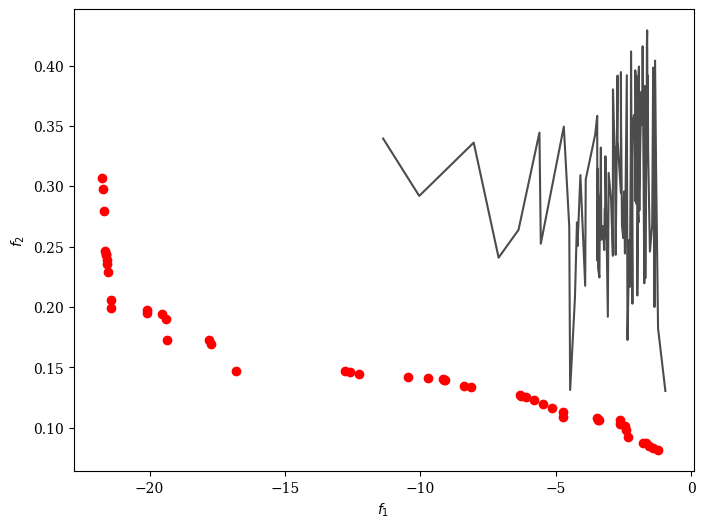

In [11]:
target_topo='uru'
problem = carbon_problem()
res = minimize(problem,
                   algorithm,
                   termination=('n_gen', 500),
                   seed=1,
                   save_history=True,verbose=True)
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, color="red")
plot.show()
final_mofs=get_mof_name_independent(target_topo,res.X)
final_results=np.vstack((get_mof_name_independent(target_topo,res.X),res.F.T)).T #[name,q_co2,lg(q_n2)]
np.savetxt("nsga_result/"+target_topo+".txt",final_results,fmt="%s")

In [12]:
test=['abf+N342+N320+N562+E58+E180+E37']
-mofnet_prediction(['abf+N342+N320+N562+E58+E180+E37'])[:,0],np.log(mofnet_n2_prediction(['abf+N342+N320+N562+E58+E180+E37'])[:,0])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-7.107813], dtype=float32)>,
 array([-1.0908568], dtype=float32))

In [13]:
topo_cn_arr[topo_cn_arr[:,0]=='dni-d']

array([['dni-d', list([24, 3]), list([2, 2])]], dtype=object)